# Comite Votação Simples

In [25]:
import numpy 
import pandas as pd

In [37]:
#data = pd.read_csv("../datasets/ds_comite_texto.csv")
#data = pd.read_csv("../datasets/ds_comite_full.csv")
#data = pd.read_csv("../datasets2/ds_comite_texto.csv")
data = pd.read_csv("../datasets2/ds_comite_full.csv")

data.head()

,id,rotulo,ADA,GRD,KNN,NB,RF,RL,SVM
0,53,FALSO,0,0,0,1,0,0,0
1,1136,VERDADE,1,1,1,1,1,0,0
2,695,FALSO,0,0,0,1,0,0,0
3,3312,VERDADE,1,1,1,1,1,1,1
4,1314,VERDADE,1,1,1,1,1,1,1


## Remove os atributos inicias para poder realizar a votação

In [38]:
#Remove os atributos inicias para poder realizar a votação
data = data.drop('id', axis=1)

In [39]:
column_list = list(data)
print(column_list)

['rotulo', 'ADA', 'GRD', 'KNN', 'NB', 'RF', 'RL', 'SVM']


In [40]:
column_list.remove('rotulo')
#column_list.remove('NB') #remove pior algoritmo

In [41]:
print(column_list)

['ADA', 'GRD', 'KNN', 'NB', 'RF', 'RL', 'SVM']


In [42]:
data['sum'] = data[column_list].sum(axis=1) 
data.head()

,rotulo,ADA,GRD,KNN,NB,RF,RL,SVM,sum
0,FALSO,0,0,0,1,0,0,0,1
1,VERDADE,1,1,1,1,1,0,0,5
2,FALSO,0,0,0,1,0,0,0,1
3,VERDADE,1,1,1,1,1,1,1,7
4,VERDADE,1,1,1,1,1,1,1,7


In [43]:
#Numero de votos para ser real 
NUM=4 
#NUM=3
data.loc[data['sum'] >= NUM,'vote'] = 1
data.loc[data['sum'] < NUM,'vote'] = 0
data.head()

,rotulo,ADA,GRD,KNN,NB,RF,RL,SVM,sum,vote
0,FALSO,0,0,0,1,0,0,0,1,0.0
1,VERDADE,1,1,1,1,1,0,0,5,1.0
2,FALSO,0,0,0,1,0,0,0,1,0.0
3,VERDADE,1,1,1,1,1,1,1,7,1.0
4,VERDADE,1,1,1,1,1,1,1,7,1.0


In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

X = data['rotulo']

#Transforma para 0 e 1
encoder = LabelEncoder()
encoder.fit(X)
encoded_X = encoder.transform(X)

y = data['vote']

print(confusion_matrix(encoded_X, y))
print(classification_report(encoded_X, y))

[[293  86]
 [ 43 570]]
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       379
           1       0.87      0.93      0.90       613

    accuracy                           0.87       992
   macro avg       0.87      0.85      0.86       992
weighted avg       0.87      0.87      0.87       992



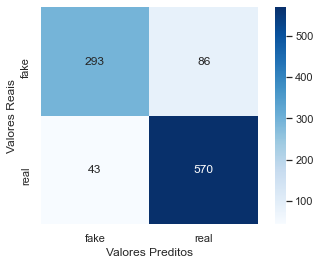

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

mat = confusion_matrix(encoded_X, y)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Blues", cbar=True,
            xticklabels=['fake','real'],
            yticklabels=['fake','real'])
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais');

auc:  0.8514701261583889


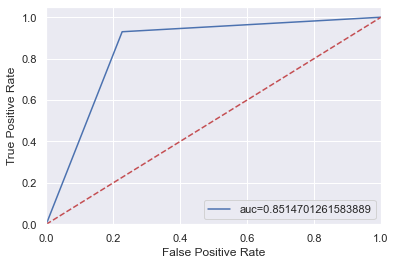

In [46]:
from sklearn import metrics

auc = metrics.roc_auc_score(encoded_X, y)
print("auc: ",str(auc))
fpr, tpr, _ = metrics.roc_curve(encoded_X, y)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

## Validação Cruzada

In [47]:
from sklearn.model_selection import StratifiedKFold, KFold 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, f1_score
from sklearn.preprocessing import StandardScaler

# fix random seed for reproducibility
seed = 109
numpy.random.seed(seed)

X = encoded_X
Y = y

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
cvaucs = []
f1s = []
cvfprs0 = []
cvfprs1 = []
cvfprs2 = []
cvtprs0 = []
cvtprs1 = []
cvtprs2 = []
for train, test in kfold.split(X, Y):   
    rept = classification_report(X[test], Y[test], output_dict=True)
    #print("%s: %.4f%%" % (model.metrics_names[1], scores[1]))
    cvscores.append(rept['accuracy'])
    #Calculo do AUC
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(X[test], Y[test])      
    auc_keras = auc(fpr_keras, tpr_keras)
    #print("auc_keras %.4f%%" % (auc_keras))
    cvaucs.append(auc_keras)
    
    cvfprs0.append(fpr_keras[0])
    cvfprs1.append(fpr_keras[1])
    cvfprs2.append(fpr_keras[2])
    
    cvtprs0.append(tpr_keras[0])
    cvtprs1.append(tpr_keras[1])
    cvtprs2.append(tpr_keras[2])
    
    #F1-score
    f1 = f1_score(X[test], Y[test], average="binary")
    f1s.append(f1)
    print("Acurácia: %.4f%% - AUC %.4f%% - F1 %.4f%% " % (rept['accuracy'], auc_keras, f1 ))
    
print(">> Acurácia %.4f%% (+/- %.4f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
print(">> AUC %.4f%% (+/- %.4f%%)" % (numpy.mean(cvaucs), numpy.std(cvaucs)))
print(">> F1 %.4f%% (+/- %.4f%%)" % (numpy.mean(f1s), numpy.std(f1s)))

Acurácia: 0.8400% - AUC 0.8203% - F1 0.8769% 
Acurácia: 0.8300% - AUC 0.8093% - F1 0.8682% 
Acurácia: 0.9293% - AUC 0.9194% - F1 0.9457% 
Acurácia: 0.8889% - AUC 0.8731% - F1 0.9134% 
Acurácia: 0.8889% - AUC 0.8752% - F1 0.9147% 
Acurácia: 0.8990% - AUC 0.8849% - F1 0.9219% 
Acurácia: 0.8485% - AUC 0.8286% - F1 0.8800% 
Acurácia: 0.9495% - AUC 0.9342% - F1 0.9606% 
Acurácia: 0.8182% - AUC 0.7984% - F1 0.8548% 
Acurácia: 0.8081% - AUC 0.7932% - F1 0.8430% 
>> Acurácia 0.8700% (+/- 0.0457%)
>> AUC 0.8537% (+/- 0.0480%)
>> F1 0.8979% (+/- 0.0372%)


## Curva ROC Kfold

auc:  0.8536686648033223


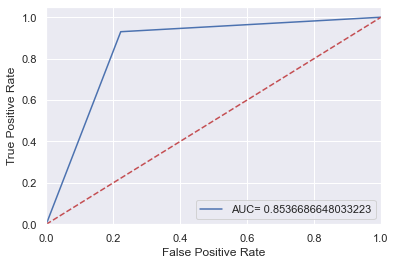

In [48]:
from sklearn import metrics

auc = numpy.mean(cvaucs)

print("auc: ",str(auc))

fpr = [numpy.mean(cvfprs0), numpy.mean(cvfprs1), numpy.mean(cvfprs2)]
tpr = [numpy.mean(cvtprs0), numpy.mean(cvtprs1), numpy.mean(cvtprs2)]

plt.plot(fpr,tpr,label="AUC= "+str(auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()